# XY-calibration (QSObright)

In [1]:
try:
    from google.colab import drive
except ModuleNotFoundError:
    import os
    os.chdir("/Users/Vincent/Nextcloud/LAM/FIREBALL/FireBallPipe")
else:
    drive.mount("/content/gdrive", force_remount=True)
    ! cd /content/gdrive/MyDrive/FIREBall-2/FB2_2023/instrument_alignment_focusing/XY_calibration/FireBallPipe

# cd /content/gdrive/MyDrive/FIREBall-2/FB2_2023/instrument_alignment_focusing/XY_calibration
# ! git clone https://github.com/vpicouet/FireBallPipe.git


| #  | Name                               | Done                     |       Comment               |
|----|------------------------------------|--------------------------|-----------------------------|
| 1  | Have a mask-detector mapping       | <input type="checkbox">  |  And send region file to zeren |
| 2  | Use the previous XY mapping        | <input type="checkbox">  | of the same mask, if never done do a new one   |
| 2.a  |Add mask rotation for F2       | <input type="checkbox">  |                             |
| 3  | Reset magnification/offset/angle   | <input type="checkbox">  |                             |
| 4  | Be sure of the slits path          | <input type="checkbox">  |  Use only regular slits, big moves, do not use slits that are seen with one line or in shadow   |
| 4.a  | Decide to use or not hysteresis compensation          | <input type="checkbox">  |  Adds ~1h in total + slight code complexity but might improve results by <1''  |
| 5  | Account from Zeren offset          | <input type="checkbox">  |                             |
| 6  | Add slits path in google drive     | <input type="checkbox">  |                             |
| 7  | Add CNES moves to google drive     | <input type="checkbox">  |                             |


In [2]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2
from functools import reduce
import sys
import numpy as np
from astropy.io import fits
from astropy import wcs, coordinates
from astropy import units as u
from astropy.wcs.utils import proj_plane_pixel_scales
from matplotlib import pyplot as plt
from astropy.table import Table, vstack 
import matplotlib.patches as patches
import unittest
from mpl_interactions import heatmap_slicer
import pandas as pd
import datetime 
# os.chdir(os.path.dirname(os.path.realpath(__file__)))
sys.path.insert(1, './Calibration')
from guider2UV.guider2UV import Guider2UV, diff_skycoord, fit_model
from guider2UV.MaskAstrometry import LocalScienceMaskProjector
from Calibration.mapping import Mapping

# encoder gains 2022:
Elg = 1.0049 #2023 FTS #0.9969 # 2023 #1.0090 2022 # Elg = 1.00379 # 2018
CEg =  1.0240 #2023 FTS #1.018  # 2023 #1.0187 2022 # CEg = 1.02928 # 2018
print("After calibration of the encoders, El is %0.5f ''/inc and Ce is %0.5f ''/inc" %(Elg*0.092,CEg*0.01))


After calibration of the encoders, El is 0.09245 ''/inc and Ce is 0.01024 ''/inc


## initialization from last xy calib
---------------------------------
This was actually a mistake, it should slways be done from the same mask (same field center), or create a new G2UV object

In [3]:
# prerequisites:
Field = "QSObright"
previous_xy_mapping = "Calibration/Mappings/2023/XY/BrightQSO_1_aftergoingtoguidestars_230822.pkl"
mask_det_map_file = "Calibration/Mappings/2023/mask_to_det_mapping/mapping-mask-det-w-0-QSObright_230825_ok_done_for_XY_full_second_round.pkl"
target_filename = 'Calibration/Targets/2022/targets_%s.csv'%(Field)
Hysteresis_compensation = False
# if input("Are you sure that you want to use Hysteresis_compensation = %s? (y/n)"%(Hysteresis_compensation))!="y":
#     raise ValueError("Please be verify the value of Hysteresis_compensation")


In [4]:
# load model from previous XY calib 
G2UV = Guider2UV(filename=previous_xy_mapping)
#changer de centre 
ra, dec, rot = 275.48, 	64.36, 70	
G2UV.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(ra*u.deg, dec*u.deg), rotation=rot*u.deg, gamma=1)

	
# eventually reset the guider-scmask rotation to 0 and magnification correction to 0.
G2UV.mask_rotation = 0.0*u.arcmin
G2UV.FieldP.gamma = 1. 
G2UV.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
G2UV.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
print(G2UV)

# # if you already know the approx angular distance between guidercenter and FOVcenter, set it:
# # G2UV.FOV_center_guider_coord = coordinates.SkyCoord(delta_x*u.deg, # x guider axis (x axis in guider local frame, see XYcalib figure)
# #                                                    delta_y*u.deg, # y guider axis (y axis guider local frame, see XYcalib figure)
# #                                                    frame = G2UV.GuiderP.localframe)

# load targets
F1 = Table.read(target_filename, format='ascii')

# load mask-UVdetector mappings
mask_det_map = Mapping(mask_det_map_file)

# if input("Are you sure that these values make sense for %s: Theta=%s, center=%s? (y/n)"%(Field, G2UV.FieldP.rotation, G2UV.FieldP.center))!="y":
#     raise ValueError("Please verify the initialization mapping")
star_target_path = "Calibration/Targets/2022/GuidingStars/QSO_guidingstars.csv"

F1_stars = Table.read(star_target_path).to_pandas()





FOV center angular position in guider <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.42402654, 36.43499699)>): (lon, lat) in deg
    (0.19791966, -0.01003477)>
FOV center pixel position in guider [array(1416.59123981), array(502.48192757)]

Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-20.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (275.48, 64.36)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.42402654, 36.43499699)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.424026537  36.4349969891  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024648264068189  0.00024664057706659  
NAXIS : 0  0

    mask_rotation: 0.0 arcmin
    FOV cent

/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_54064/1491274896.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_stars =Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_54064/1491274896.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_stars =Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))


## Alternative initialisation for new fields:
---------------------------------------

In [5]:

# f_ra, f_dec, f_rot = 11.866,	3.244, 0
# Field_center=coordinates.SkyCoord(f_ra * u.deg, f_dec * u.deg)
# # get FOVcenter & guider wcs from another field
# #  put pkl from a functionning mapping from another field
# G2UVother = Guider2UV(filename=previous_xy_mapping)
# FOVcenter = G2UVother.FOV_center_guider_coord
# guider_wcs = G2UVother.GuiderP.w
# G2UV = Guider2UV(Field_center=Field_center,
#                  Field_rotation= f_rot * u.deg,
#                  Field_gamma=1.0,  # platescale correction (need to update the polynomial in the MaskAstrometry.py)
#                  FOVcenter_guider_coord=FOVcenter,
#                  guider_wcs = guider_wcs,
#                  )
                 


## 1-  Rotate mask carousel
## 2- Diffuse UV image

Copy the offset from [this spreadsheet step "Compute offsets with previous diffuse illumination image"](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [6]:
# This offset in X and Y should be positive if the slit position in tghe new image appears to be shifted towards the top right
# diffuse_offset = np.array([0.6,1.4])
diffuse_offset = np.array([0,0])
G2UV.set_detector_mapping(mask_det_map, offsets = diffuse_offset+1) #+1 offset is to account for DS9 vs python offset
direct_map = lambda w, x, y: mask_det_map.map(w, x, y) + diffuse_offset
inv_map = lambda w, x, y: mask_det_map.inv_map(w, x - diffuse_offset[0], y - diffuse_offset[1])

## 3 - Set guider at best focus          
## 4 - Align siderostat frames           
## 5 - Go to guider reference            
## 6 - Set UV/guider best focus offset   
## 7 - Rotate mask carousel              
## 8 - Through focus in UV               
## 9 - Note open-mask guider ref point   
    

## 10 - Go through the list of slits      

['23', '36', '2', '13', '32', '11',"4"]

Here we struggled to find the good path because of faint 202/206 lines and of shadow of fiber holder

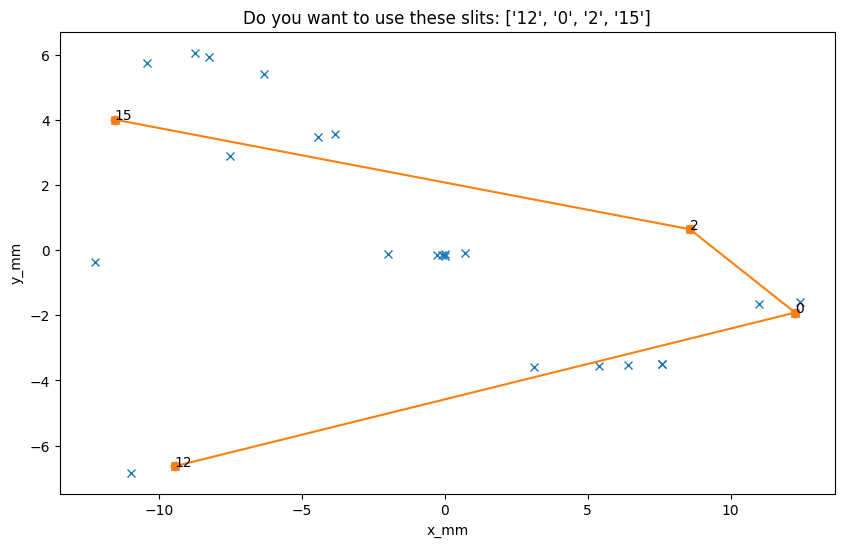

      RA            DEC     
-------------- -------------
   11.74227644   2.967784983
   11.91243088   2.993149037
   11.94680242   2.904172905
       11.6413          3.09
12.15660518316 3.20191018404
    275.672325     64.174395
    275.470206     64.649877


In [7]:
slits =["12","0","2","15"]#3 short pass
F1['Internal-count'] = F1['Internal-count'].astype(str)

F1p = F1.to_pandas()
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# selected_slits = F1[mask.values]['Internal-count',"x_mm","y_mm","ra","dec"]
selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))
ra,dec = "RA", "DEC"
x,y = "x_mm","y_mm"
plt.figure(figsize=(10,6))
plt.plot(F1[x],F1[y],"x")
plt.plot(selected_slits[x],selected_slits[y],"-o")
for s in selected_slits:
    plt.text(s[x],s[y],s["Internal-count"])
plt.xlabel("x_mm")
plt.ylabel("y_mm")
plt.title("Do you want to use these slits: %s"%(slits))
plt.show()

selected_slits = selected_slits['Internal-count',x,y,ra,dec]
slit_path = selected_slits# vstack((selected_slits,selected_slits[::-1]) )
slit_path["ra_diff"] = list((slit_path[ra][:-1] - slit_path[ra][1:])*np.cos(slit_path[dec][:-1]*np.pi/180)) + [0]
slit_path["dec_diff"] = list((slit_path[dec][:-1] - slit_path[dec][1:])) + [0]

slit_path["ra_diff"] *= 3600
slit_path["dec_diff"] *= 3600
slit_path["angular_distance"] = np.sqrt(slit_path["ra_diff"]** 2 + slit_path["dec_diff"]** 2)
try:
    slit_path.to_pandas().to_clipboard()
except Exception:
    pass
slit_path
stars_and_slits = vstack([selected_stars["RA","DEC"],selected_slits["RA","DEC"]])
print(stars_and_slits)

The slits table has been copied. Add it to the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [8]:
moves, flags, slit_coords = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation,Elg=Elg,CEg=CEg)
moves = pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"])#,dtype=[("EL",float),("CE",float),("UV_image",float)])
# assert moves.sum(axis=0)[0] <0.1
# assert moves.sum(axis=0)[1] <0.1
moves["UV_image"] = moves["UV_image"].astype(bool)
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

# slit_path['lon'] = [s.lon.deg*3600 for s in slits_coord]
# slit_path['lat'] =  [s.lat.deg*3600 for s in slits_coord]
# slit_path
print("(They have been copied to clipboard, paste it in the spreadsheet)")
try:
    moves.to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves
if ~Hysteresis_compensation:
    print("Carefull, with Hysteresis_compensation==%s the last move to return to the guider is not given. You just need to do -∑all moves"%(Hysteresis_compensation))
    print("You should then add EL=%0.4f and CE=%0.4f"%(moves.sum(axis=0)[0],moves.sum(axis=0)[1]))


slit position in mm on mask: [-9.44640593 -6.63744582]
slit position in mm on mask: [12.25014337 -1.91624601]
slit position in mm on mask: [8.56723307 0.64558374]
slit position in mm on mask: [-11.54607195   4.01426783]

targets local coords in siderostat local frame:
EL: 73.2 arcsec ; CE: -375.3 arcsec
EL: 273.3 arcsec ; CE: 527.2 arcsec
EL: 381.9 arcsec ; CE: 374.0 arcsec
EL: 524.7 arcsec ; CE: -462.6 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)
Carefull, with Hysteresis_compensation==False the last move to return to the guider is not given. You just need to do -∑all moves
You should then add EL=524.6607 and CE=-462.6065


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

Copy below the observed slits position from the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [9]:
# fig, (ax0,ax1) = plt.subplots(1,2)
# ax0.plot(slits_coord_obs_det[:,1]-slits_coord_obs_det[:,1].mean(),slits_coord_obs_det[:,0]-slits_coord_obs_det[:,0].mean(),"o")
# ax1.plot(-46*selected_slits["x_mm"],46*selected_slits["y_mm"],"o")
# ax1.plot(slits_coord_obs_det[:,1]-slits_coord_obs_det[:,1].mean(),slits_coord_obs_det[:,0]-slits_coord_obs_det[:,0].mean(),"o")


In [9]:

slits_coord_obs_det = np.array([
[1214,	1742  ],
[1541,	70  ],
[1706,	355  ],
[1934,	1911  ],
]) 


valid = np.isfinite(slits_coord_obs_det[:,0])
obs_wave = 0.20619
print("wave: ", obs_wave)
slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# slits_valid = slits[valid]
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
slits_coord_obs

# if input("Are you sure you computed the barycenter on the line %s? Remember that it's better to use 206 line to probe a bigger part of the detector. It might require gain and longer exposure though. Be sure to always compute the centroid on the same line. (y/n)"%(obs_wave))!="y":
#     raise ValueError("Please change obs_wave parameter (c)")


wave:  0.20619


[<SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.04032215, 0.20806439)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.15361471, -0.30031547)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.21241799, -0.21388438)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.28883224, 0.25894867)]>]

### look at siderostat frame hysteresis 

## 11- Note open-mask guider ref point
## 12- Update model with observed slit positions

Fitting rotation and translation
theta: -19.0 arcmin
dx: 4.1 arcsec
dy: 13.6 arcsec
variances: [1.79323648 0.50028549 0.59820963]

residuals in arcsec: [[ 6.3999694  -6.78965145]
 [ 1.8676959   9.02430883]
 [-2.93427625  5.24434261]
 [-5.33338906 -7.47899999]]
max residual in EL,CE 6.4, 9.0 arcsec
mean residual in EL,CE 4.5, 7.3 arcsec
After updating:
    mask_rotation: -18.997940712982995 arcmin
    FOV center in guider: 1420.77558304616 x 512.8389714293608 pix = 716.4091038433602 arcsec x -26.51151196100787 arcsec arcsec
    mask_magnification correction: 1.0  
    


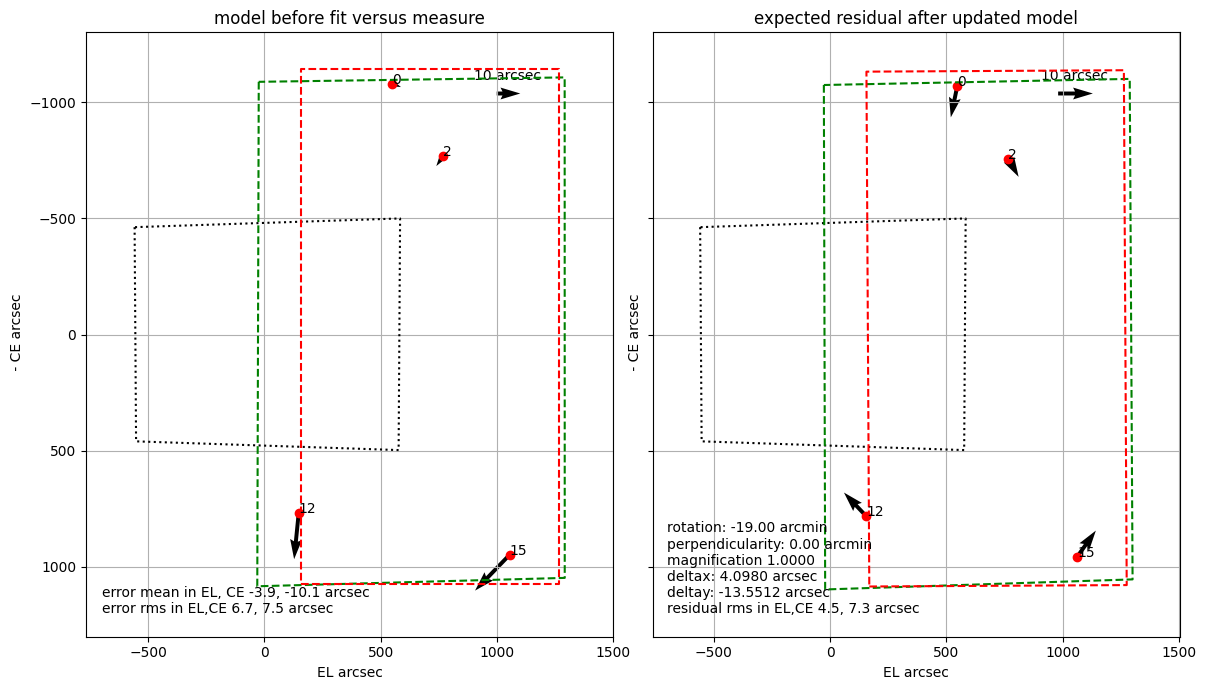


            Left plot verification
            [x]  Error mean give the average of the residuals (=arrows=model-measurements) before model improvement
            This Error mean must be <5" at the last interation
            [x]  Error rms is the rms of the arrows. This might potentiallly due to rotation or bad cutting of the slits
            [x]  Crosses show targets and bright stars position using the updated model. For the final iteration + & o should be gathered on both plots
            Right plot verification
            [x]  Residual rms are residuals between new model and measures after fitting an offset + rotation.
            If should always be <5" even if we are far from the slits
            [x] Rotation should be <1deg, magnification should be 1
            [x] Delta x and y should be close to 0 for the last iteration.
            
            
            
            


In [10]:
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor, residuals = G2UV.update_model(slits_coord_valid, slits_coord_obs, plot=True, figsize=(12,7), labels=slits,gamma=False)#,selected_stars=stars_and_slits)


### check updating with fitting magnification

In [11]:
# G2UVtest=G2UVcor.copy()
# G2UVtest.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
# G2UVtest.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
# G2UVtest.FieldP.gamma = 1.
# print(G2UVtest)
# G2UVcor_test, residuals = G2UVtest.update_model(slits_coord_valid, slits_coord_obs, labels=slits, plot=True, figsize=(16,6), gamma=True,inplace=False)#,selected_stars=stars_and_slits)


In [13]:
selected_slits.to_pandas().to_clipboard()

### Verify what magnification it predicts
### save corrected model for future use (eg redo the calib on same field)

# Another try in open mask

In [12]:
# slits =[ "16","0","12","3"]# short pass
slits =["12", "16","0","11","2","15"]#3 short pass

selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))

moves, flags, slit_coords = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation,Elg=Elg,CEg=CEg)
moves = pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"])
# assert moves.sum(axis=0)[0] <0.1
# assert moves.sum(axis=0)[1] <0.1
moves["UV_image"] = moves["UV_image"].astype(bool)
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

# slit_path['lon'] = [s.lon.deg*3600 for s in slits_coord]
# slit_path['lat'] =  [s.lat.deg*3600 for s in slits_coord]
# slit_path
print("(They have been copied to clipboard, paste it in the spreadsheet)")
try:
    moves.to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves


slit position in mm on mask: [-9.44640593 -6.63744582]
slit position in mm on mask: [-12.23000019  -0.36216972]
slit position in mm on mask: [12.25014337 -1.91624601]
slit position in mm on mask: [-8.74712732  6.06767877]
slit position in mm on mask: [8.56723307 0.64558374]
slit position in mm on mask: [-11.54607195   4.01426783]

targets local coords in siderostat local frame:
EL: 77.3 arcsec ; CE: -381.5 arcsec
EL: 344.0 arcsec ; CE: -495.8 arcsec
EL: 272.4 arcsec ; CE: 522.0 arcsec
EL: 615.7 arcsec ; CE: -349.5 arcsec
EL: 381.8 arcsec ; CE: 369.4 arcsec
EL: 529.3 arcsec ; CE: -466.4 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)


,EL,CE,UV_image,EL_abs,CE_abs
0,77.346133,-381.493144,True,77.346133,-381.493144
1,266.626026,-114.338016,True,343.972159,-495.831159
2,-71.602583,1017.866585,True,272.369576,522.035425
3,343.312290,-871.522478,True,615.681866,-349.487053
4,-233.867943,718.924862,True,381.813923,369.437809
5,147.490873,-835.815784,True,529.304796,-466.377975


wave:  0.20619
Fitting rotation and translation
theta: -2.2 arcmin
dx: 1.0 arcsec
dy: 3.9 arcsec
variances: [1.52729416 0.42596644 0.52522417]

residuals in arcsec: [[  7.90359406  -5.10897232]
 [ -0.30167306 -10.67364607]
 [  1.84102086  12.94179629]
 [ -3.80112231  -0.31127265]
 [ -2.14401624   8.15834691]
 [ -3.49780332  -5.00625217]]
max residual in EL,CE 7.9, 12.9 arcsec
mean residual in EL,CE 4.0, 8.2 arcsec
After updating:
    mask_rotation: -21.212976593994387 arcmin
    FOV center in guider: 1421.813460358297 x 516.5873677265938 pix = 717.367932109553 arcsec x -23.028948933379493 arcsec arcsec
    mask_magnification correction: 1.0  
    


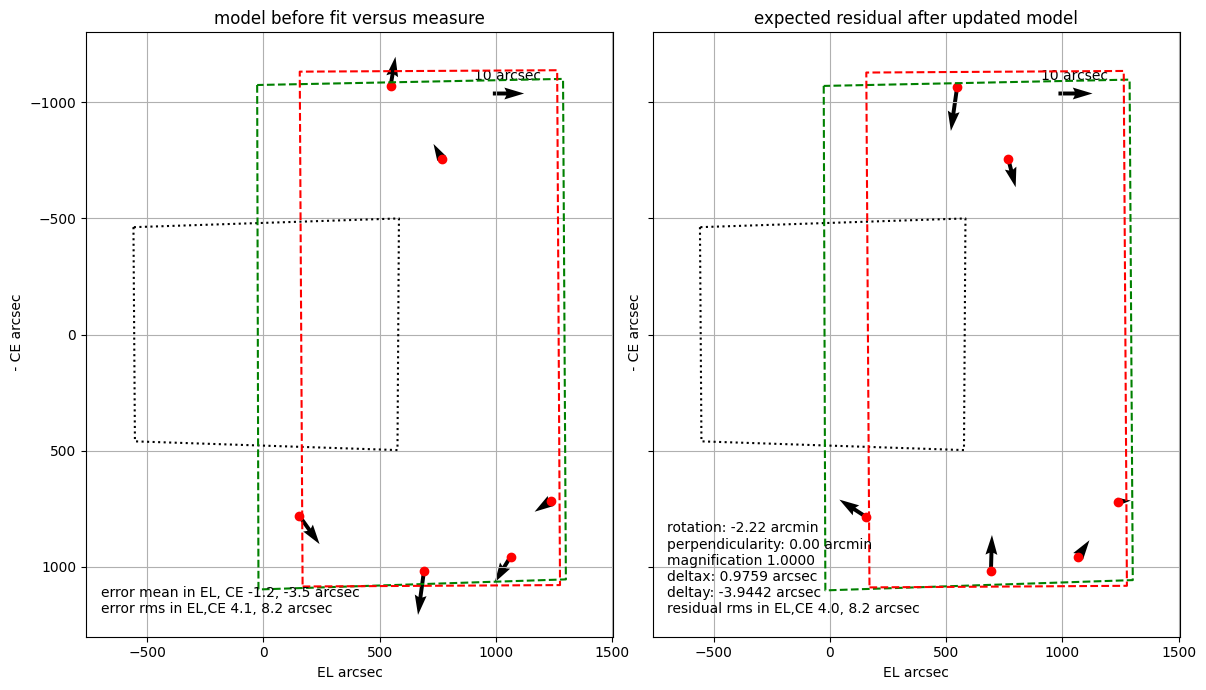


            Left plot verification
            [x]  Error mean give the average of the residuals (=arrows=model-measurements) before model improvement
            This Error mean must be <5" at the last interation
            [x]  Error rms is the rms of the arrows. This might potentiallly due to rotation or bad cutting of the slits
            [x]  Crosses show targets and bright stars position using the updated model. For the final iteration + & o should be gathered on both plots
            Right plot verification
            [x]  Residual rms are residuals between new model and measures after fitting an offset + rotation.
            If should always be <5" even if we are far from the slits
            [x] Rotation should be <1deg, magnification should be 1
            [x] Delta x and y should be close to 0 for the last iteration.
            
            
            
            


In [13]:
slits_coord_obs_det = np.array([
[  1221,	1751       ],
[  1645,	1968     ],
[  1539,	80       ],
[  2077,	1703       ],
[  1706,	363       ],
[  1942,	1917      ]])



valid = np.isfinite(slits_coord_obs_det[:,0])
obs_wave =  0.20619
print("wave: ", obs_wave)
slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# slits_valid = slits[valid]
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
slits_coord_obs

slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor, residuals = G2UV.update_model(slits_coord_valid, slits_coord_obs, plot=True, figsize=(12,7),gamma=False)#selected_stars=stars_and_slits)#, labels=slits)#



In [15]:
G2UVcor.save(filename="Calibration/Mappings/2023/XY/%s_XY_gamma%0.2f_%s_good_second_try_-100.pkl"%(Field, G2UVcor.FieldP.gamma, datetime.datetime.now().strftime("%y%m%d")))


Dumping to Calibration/Mappings/2023/XY/QSObright_XY_gamma1.00_230825_good_second_try_-100.pkl


In [17]:
# G2UVtest=G2UVcor.copy()
# G2UVtest.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
# G2UVtest.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
# G2UVtest.FieldP.gamma = 1.
# print(G2UVtest)
# G2UVcor_test, residuals = G2UVtest.update_model(slits_coord_valid, slits_coord_obs, labels=slits, plot=True, figsize=(16,6), gamma=True,inplace=False,selected_stars=stars_and_slits)


In [14]:

moves, flags, slit_coords = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation,Elg=Elg,CEg=CEg)
moves = pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"])
# assert moves.sum(axis=0)[0] <0.1
# assert moves.sum(axis=0)[1] <0.1
moves["UV_image"] = moves["UV_image"].astype(bool)
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

# slit_path['lon'] = [s.lon.deg*3600 for s in slits_coord]
# slit_path['lat'] =  [s.lat.deg*3600 for s in slits_coord]
# slit_path
print("(They have been copied to clipboard, paste it in the spreadsheet)")
try:
    moves.to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves

slit position in mm on mask: [-9.44640593 -6.63744582]
slit position in mm on mask: [-12.23000019  -0.36216972]
slit position in mm on mask: [12.25014337 -1.91624601]
slit position in mm on mask: [-8.74712732  6.06767877]
slit position in mm on mask: [8.56723307 0.64558374]
slit position in mm on mask: [-11.54607195   4.01426783]

targets local coords in siderostat local frame:
EL: 78.1 arcsec ; CE: -383.4 arcsec
EL: 344.8 arcsec ; CE: -497.5 arcsec
EL: 272.5 arcsec ; CE: 520.3 arcsec
EL: 616.4 arcsec ; CE: -351.0 arcsec
EL: 382.1 arcsec ; CE: 367.8 arcsec
EL: 530.1 arcsec ; CE: -468.0 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)


,EL,CE,UV_image,EL_abs,CE_abs
0,78.081186,-383.371498,True,78.081186,-383.371498
1,266.702045,-114.169838,True,344.783230,-497.541336
2,-72.271123,1017.824935,True,272.512108,520.283599
3,343.885715,-871.308508,True,616.397822,-351.024909
4,-234.340789,718.779549,True,382.057033,367.754641
5,148.040157,-835.725503,True,530.097190,-467.970863


wave:  0.20619
Fitting rotation and translation
theta: 2.4 arcmin
dx: 0.4 arcsec
dy: -0.0 arcsec
variances: [1.92985912 0.50082808 0.55934948]

residuals in arcsec: [[ -4.06079992 -13.34597598]
 [  7.12170067  14.59026477]
 [  9.05505898 -11.56216522]
 [-12.11595974  10.31787642]]
max residual in EL,CE 12.1, 14.6 arcsec
mean residual in EL,CE 8.6, 12.6 arcsec
After updating:
    mask_rotation: -0.30492580900683625 deg
    FOV center in guider: 1416.5912398054743 x 502.4819275743537 pix = 712.5107795749182 arcsec x -36.12516841514252 arcsec arcsec
    mask_magnification correction: 1.0  
    
[-0.07763088 -0.05317709 -0.14233403  0.19427709  0.15432677  0.34625013
         nan] [ 0.11499282 -0.05506729 -0.08892488  0.28043945 -0.2999625   0.19691145
         nan]
[-0.07763088 -0.05317709 -0.14233403  0.19427709  0.15432677  0.34625013
         nan] [ 0.11499282 -0.05506729 -0.08892488  0.28043945 -0.2999625   0.19691145
         nan]


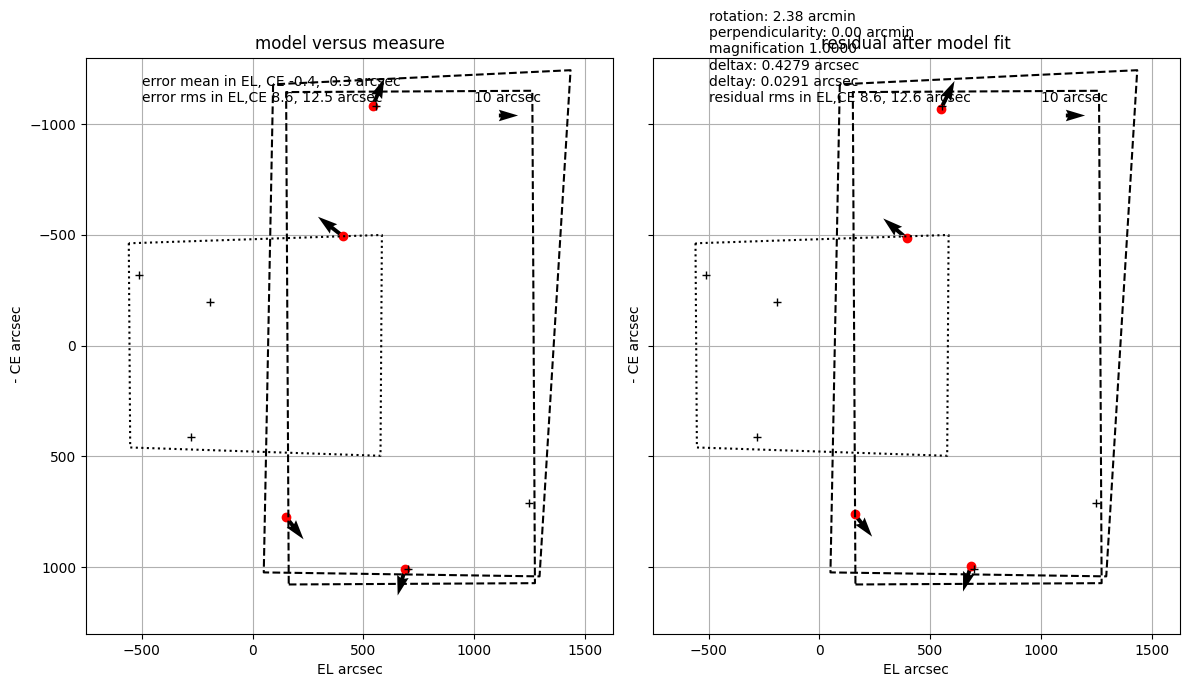


            Left plot verification
            [x]  Error mean give the average of the residuals (=arrows=model-measurements) before model improvement
            This Error mean must be <5" at the last interation
            [x]  Error rms is the rms of the arrows. This might potentiallly due to rotation or bad cutting of the slits
            [x]  Crosses show targets and bright stars position using the updated model. For the final iteration + & o should be gathered on both plots
            Right plot verification
            [x]  Residual rms are residuals between new model and measures after fitting an offset + rotation.
            If should always be <5" even if we are far from the slits
            [x] Rotation should be <1deg, magnification should be 1
            [x] Delta x and y should be close to 0 for the last iteration.
            
            
            
            


In [16]:
# slits_coord_obs_det = np.array([
# [ 1644,	1967    ],
# [ 1538,	78 ],
# [ 1220,	1750   ],
# [ 1420,	608  ]])



# valid = np.isfinite(slits_coord_obs_det[:,0])
# obs_wave =  0.20619
# print("wave: ", obs_wave)
# slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# # slits_valid = slits[valid]
# slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
# slits_coord_obs

# slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
# weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
# G2UVcor, residuals = G2UV.update_model(slits_coord_valid, slits_coord_obs, plot=True, figsize=(12,7),gamma=False,selected_stars=stars_and_slits)#, labels=slits)#




Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-90.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (11.866, 3.244)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.42402654, 36.43499699)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.424026537  36.4349969891  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024648264068189  0.00024664057706659  
NAXIS : 0  0

    mask_rotation: -0.30492580900683625 deg
    FOV center in guider: 1416.5912398054743x502.4819275743537 pix

Fitting rotation, translation and magnification
gamma: 1.014 
theta: 2.4 arcmin
dx: -6.0 arcsec
dy: -0.8 arcsec
variances: [5.61373262e-04 1.92985912e+00 5.60089824e-01 5.60089824e-01]

residuals in arcsec: [[ -0.58859

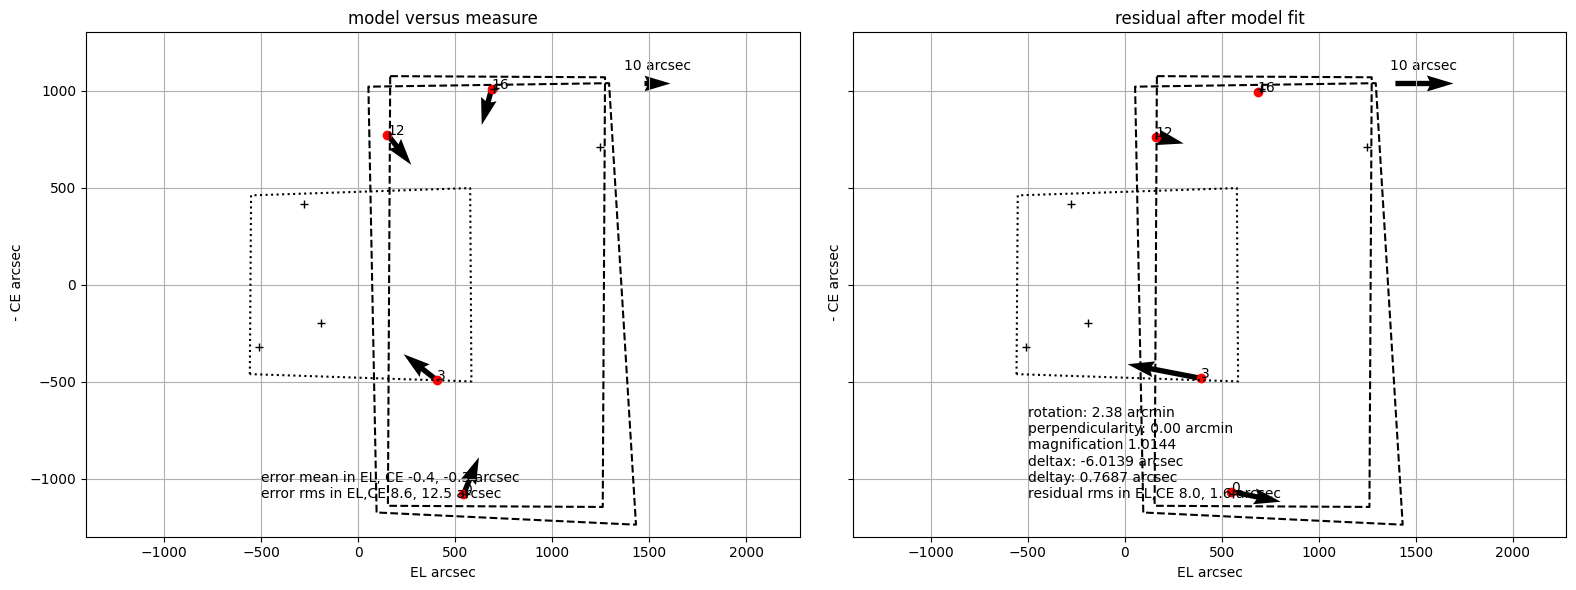


            Left plot verification
            [x]  Error mean give the average of the residuals (=arrows=model-measurements) before model improvement
            This Error mean must be <5" at the last interation
            [x]  Error rms is the rms of the arrows. This might potentiallly due to rotation or bad cutting of the slits
            [x]  Crosses show targets and bright stars position using the updated model. For the final iteration + & o should be gathered on both plots
            Right plot verification
            [x]  Residual rms are residuals between new model and measures after fitting an offset + rotation.
            If should always be <5" even if we are far from the slits
            [x] Rotation should be <1deg, magnification should be 1
            [x] Delta x and y should be close to 0 for the last iteration.
            
            
            
            


In [19]:
# G2UVtest=G2UVcor.copy()
# G2UVtest.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
# G2UVtest.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
# G2UVtest.FieldP.gamma = 1.
# print(G2UVtest)
# G2UVcor_test, residuals = G2UVtest.update_model(slits_coord_valid, slits_coord_obs, labels=slits, plot=True, figsize=(16,6), gamma=True,inplace=False,selected_stars=stars_and_slits)


## 13 - Rotate carousel to science mask
## 14 - Note open-mask guider ref point
## 15 - Check corrected model through science mask

In [14]:
# moves, flags, slit_coords = G2UVcor.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
# moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))
# print("(They have been copied to clipboard, paste it in the spreadsheet)")
# moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
# moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

# try:
#     moves.to_pandas().to_clipboard()
# except Exception as e:
#     print("Could not copy: ", e)
# moves

# # new_cat = slit_path[:-1]
# # new_cat["EL"] = moves["EL"][1:]
# # new_cat["CE"] = moves["CE"][1:]

# # new_cat["El_sky"] = new_cat["EL"]  * 2 * Elg
# # new_cat["Cel_sky"] = new_cat["CE"] * 2 * CEg
# # new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
# # new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
# # new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
# # new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# # # new_cat
# # # new_cat.to_pandas().to_clipboard()



# # plt.figure()
# # plt.plot(new_cat["angular_distance"],-new_cat["EL_dec_ratio"],"P",label="El move / dec angular distance between targets")
# # plt.plot(new_cat["angular_distance"],-new_cat["CE_ra_ratio"],"X",label="CE move / ra angular distance between targets")
# # plt.plot(new_cat["angular_distance"],new_cat["frame_divided_sky"],"o",label="Sky angular move / angular distance between targets")
# # plt.legend()
# # plt.show()
# # new_cat#["ra_diff","dec_diff","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]#,"EL_moves","CE_moves"


slit position in mm on mask: [-9.44640593 -6.63744582]
slit position in mm on mask: [-12.23000019  -0.36216972]
slit position in mm on mask: [12.25014337 -1.91624601]
slit position in mm on mask: [-8.74712732  6.06767877]
slit position in mm on mask: [8.56723307 0.64558374]
slit position in mm on mask: [-11.54607195   4.01426783]

targets local coords in siderostat local frame:
EL: 77.3 arcsec ; CE: -381.5 arcsec
EL: 344.0 arcsec ; CE: -495.8 arcsec
EL: 272.4 arcsec ; CE: 522.0 arcsec
EL: 615.7 arcsec ; CE: -349.5 arcsec
EL: 381.8 arcsec ; CE: 369.4 arcsec
EL: 529.3 arcsec ; CE: -466.4 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)


EL,CE,UV_image,EL_abs,CE_abs
float64,float64,float64,float64,float64
77.34613292131156,-381.49314366471015,1.0,77.34613292131156,-381.49314366471015
266.6260261917319,-114.33801570662276,1.0,343.97215911304346,-495.8311593713329
-71.60258296021351,1017.8665846104273,1.0,272.36957615282995,522.0354252390944
343.31229022244173,-871.5224779821458,1.0,615.6818663752717,-349.48705274305144
-233.86794323512729,718.9248620080391,1.0,381.8139231401444,369.43780926498766
147.49087283014782,-835.8157843756404,1.0,529.3047959702923,-466.37797511065276


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

Here we just wanted to do another try to verify that the least square gives consistent results

# here we should not rerun the model because we tronc the fiber so we actually do not get the real center

In [16]:
G2UVcor.save(filename="Calibration/Mappings/2023/XY/QSO1_XY_230621_Field3.pkl")

Dumping to Calibration/Mappings/2022/XY/QSO1_XY_230621_Field3.pkl



## 16 - Note science-mask guider ref point
## 17 - Go through the Star sequence We begin by QSO 5
 [29, 34, 18, 14]
we did not have the time to do this because G2UV was not well

In [22]:
selected_stars["RA","DEC","g mag","x deg","y deg"].to_pandas().to_clipboard()

In [25]:
stars =  [27,28,26] #QSOV 1
selected_stars =Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
ra, dec, rot = 11.865604,	3.244401	,	0

G2UVcor.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(ra*u.deg, dec*u.deg), rotation=rot*u.deg, gamma=1)


star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()


# G2UVcor.plot_fit([], [],residuals=[], labels=None, sol=None, figsize=(15,8), quiverscale=10, G2UVcor=None, selected_stars=selected_stars)



targets local coords in siderostat local frame:
EL: -93.6 arcsec ; CE: 90.7 arcsec
EL: -253.4 arcsec ; CE: 150.1 arcsec
EL: -137.2 arcsec ; CE: -208.3 arcsec

siderostat moves sequence: 


In [26]:
selected_stars.to_pandas().to_clipboard()
star_moves


,EL,CE,Image
0,-93.628393,90.719926,1.0
1,-159.752127,59.382618,1.0
2,116.208126,-358.354227,1.0


In [27]:


stars = [22,23,24] #QSOV 14
#back to guider center
ra, dec, rot = 275.48	,64.36	,70

G2UVcor.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(ra*u.deg, dec*u.deg), rotation=rot*u.deg, gamma=1)

selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
G2UVcor.save(filename="Calibration/Mappings/2023/XY/QSO1_XY_230621_Field4.pkl")

# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()
star_moves
print("RA=%0.1f, DEC=%0.1f, rot=%s\n stars =  \n%s"%(ra, dec, rot ,selected_stars[selected_stars.colnames[:5]]))
# G2UVcor.plot_fit([], [],residuals=[], labels=None, sol=None, figsize=(15,8), quiverscale=10, G2UVcor=None, selected_stars=selected_stars)


Dumping to Calibration/Mappings/2023/XY/QSO1_XY_230621_Field4.pkl

targets local coords in siderostat local frame:
EL: -31.6 arcsec ; CE: 163.2 arcsec
EL: 68.8 arcsec ; CE: -247.2 arcsec
EL: -246.2 arcsec ; CE: -20.8 arcsec

siderostat moves sequence: 
RA=275.5, DEC=64.4, rot=70
 stars =  
Internal count      RA         DEC     g mag x deg
-------------- ----------- ----------- ----- -----
            22 275.0817436 64.20298882   7.1    --
            23  275.011913 64.44115309  11.0    --
            24 274.7384847 64.25807469   8.9    --


In [28]:
selected_stars.to_pandas().to_clipboard()


In [29]:
G2UVcor.save(filename="Calibration/Mappings/2023/XY/BrightQSO_1_aftergoingtoguidestars_230822_second_round.pkl")

Dumping to Calibration/Mappings/2023/XY/BrightQSO_1_aftergoingtoguidestars_230822_second_round.pkl
